In [1]:
import numpy as np
import pandas as pd

# P1 Carga y Limpieza de datos

### 1- . Carga

In [2]:
def obtener_semana(week):
    week = str(week)
    # Traemos los dataframe
    all_info = pd.read_csv('./data/raw/w'+week +
                           '/metrocuadrado_all_w'+week+'.csv')
    all_info.drop_duplicates(inplace=True)
    furnished = pd.read_csv('./data/raw/w'+week +
                            '/metrocuadrado_furnished_w'+week+'.csv')
    furnished.drop_duplicates(inplace=True)

    # Merge que identifica furnished dentro de all_info
    df = pd.merge(all_info, furnished, on=['property_type|rent_type|location', 'details', 'url', 'surface', 'price'],
                  how='outer', indicator=True)
    df.rename(columns={'n_rooms_x': 'n_rooms', 'n_bath_x': 'n_bath',
                       'metrocuadrado_index_x': 'metro_cuadrado'}, inplace=True)

    # Indices que solo hay en furnished
    indices = df[df._merge == 'right_only'].index
    for i in indices:
        df.loc[i, 'n_rooms'] = df.loc[i, 'n_rooms_y']
        df.loc[i, 'n_bath'] = df.loc[i, 'n_bath_y']
        df.loc[i, 'metro_cuadrado'] = df.loc[i, 'metrocuadrado_index_y']

    # Dropeamos los _y
    df.drop(['n_rooms_y', 'n_bath_y', 'metrocuadrado_index_y'],
            axis=1, inplace=True)

    # Dropeamos los duplicados y reseatmos indice
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [3]:
def append_dataframes():
    week_list = range(13, 18)
    df = pd.DataFrame()

    for week in week_list:
        df = df.append(obtener_semana(week))

    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [4]:
# Iniciar Data frame
df = append_dataframes()
df

,property_type|rent_type|location,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge
0,"Casa en Arriendo, LA SOLEDAD NORTE Bogotá D.C..",$1.050.000,3,2,63.0 m2,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only
1,"Casa en Arriendo, CIUDAD SALITRE SUR-ORIENTAL ...",$3.930.000,3,2,100.0 m2,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both
2,"Casa en Arriendo, VILLA DE LOS ALPES II SECTOR...",$750.000,3,1,90.0 m2,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only
3,"Casa en Arriendo, PARIS GAITAN Bogotá D.C..",$3.400.000,5,4,71.0 m2,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,left_only
4,"Casa en Arriendo, BALCONES DE ORIENTE Bogotá D...",$1.560.000,4,3,96.0 m2,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,left_only
...,...,...,...,...,...,...,...,...,...
16374,"Apartamento en Arriendo, SANTA BIBIANA Bogotá ...",$2.600.000,1,2,60.0 m2,"Se arrienda precioso apartamento amoblado, con...",https://www.metrocuadrado.com/inmueble/arriend...,63.4,right_only
16375,"Apartamento en Arriendo, SANTA BARBARA OCCIDEN...",$2.350.000,1,1,43.0 m2,CÓMODO APARTAMENTO EN ARRIENDO UBICADO EN EL B...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,right_only
16376,"Apartamento en Arriendo, CHICO NORTE Bogotá D.C..",$1.750.000,1,1,48.0 m2,Apartamentototalmente amoblado de 47 metros c...,https://www.metrocuadrado.com/inmueble/arriend...,39.4,right_only
16377,"Apartamento en Arriendo, LA CABRERA Bogotá D.C..",$3.900.000,2,3,102.0 m2,Hermoso y acogedor apartamento completamente a...,https://www.metrocuadrado.com/inmueble/arriend...,51.6,right_only


Si hay furnished que no hay en all, identificados como 'right_only' de la columna _merge

### 2- . Limpieza

##### a)

In [5]:
# Limpiamos la columna price
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace('.', '')
df['price'] = df['price'].apply(float)

In [6]:
# Limpiamos la columna surface
df['surface'] = df['surface'].str.replace('m2', '')
df['surface'] = df['surface'].apply(float)

In [7]:
# Limpiamos n_rooms y n_baths, sujeto a cambios
df['n_rooms'] = df['n_rooms'].replace('5+', 6)
df['n_rooms'].fillna(3, inplace=True)
df['n_rooms'] = df['n_rooms'].apply(float)

df['n_bath'] = df['n_bath'].replace('5+', 6)
df['n_bath'].fillna(3, inplace=True)
df['n_bath'] = df['n_bath'].apply(float)

Vemos los Dtype

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16379 entries, 0 to 16378
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   property_type|rent_type|location  16379 non-null  object  
 1   price                             16379 non-null  float64 
 2   n_rooms                           16379 non-null  float64 
 3   n_bath                            16379 non-null  float64 
 4   surface                           16379 non-null  float64 
 5   details                           16269 non-null  object  
 6   url                               16379 non-null  object  
 7   metro_cuadrado                    16379 non-null  float64 
 8   _merge                            16379 non-null  category
dtypes: category(1), float64(5), object(3)
memory usage: 1.0+ MB


##### b)

In [9]:
# Split de la comuna
s = pd.Series(df.keys())
split = s.str.split('|', expand=True)

# Columnas de transicion
df[['property_type+rent_type', 'location']] = df['property_type|rent_type|location'].str.split(',', expand=True)
df[['property_type','rent_type']] = df['property_type+rent_type'].str.split(' en ', expand=True)

# Dropeamos las extra
df = df.drop(['property_type|rent_type|location', 'property_type+rent_type'], axis=1)

### 3- . Creación de columnas indicadoras

#### a)

In [10]:
# Creamos columna precio m2
df['precio_m2'] = df['price']/df['surface']

#### b)

In [11]:
def num_garajes(url):
    url_splitted = url.split('-garajes')
    # Si no hacemos split
    if len(url_splitted) == 1:
        return 0
    else:
        # Agarramos las ultimos dos caracteres XX-garajes
        n = url_splitted[0][-2:]
        # Si es del tipo -1-garajes, devolvemos 1
        if n[0] == '-':
            return n[1]
        return n


# Creamos la columna n_garajes
df['n_garajes'] = df['url'].apply(num_garajes)

In [12]:
# Limpiamos n_garajes, sujeto a cambios
df['n_garajes'] = df['n_garajes'].replace('4+',5)
df['n_garajes'] = df['n_garajes'].apply(float)

### 4- . Clasificación por tipo de producto

In [13]:
# Inicializamos la columna tipo
df['tipo'] = -1


def clasifica_producto(df):
    # Areas
    area_min = [80, 120, 180, 240, 360, 40, 60, 80]
    area_max = [120, 180, 240, 360, 460, 60, 80, 120]

    # Query
    for tipo_prod in range(1, 9):
        minimo = area_min[tipo_prod-1]
        maximo = area_max[tipo_prod-1]
        # Query para tipos 1-5
        if tipo_prod < 6:
            query = 'property_type == "Casa" and {} < surface < {}'.format(minimo, maximo)
            indices = df.query(query).index
            for i in indices:
                df.loc[i, 'tipo'] = tipo_prod
        else:
            query = 'property_type == "Apartamento" and {} < surface < {}'.format(minimo, maximo)
            indices = df.query(query).index
            for i in indices:
                df.loc[i, 'tipo'] = tipo_prod

    return df


# Actualizamos el dataframe
df = clasifica_producto(df)

In [14]:
df

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,rent_type,precio_m2,n_garajes,tipo
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,Arriendo,16666.666667,1.0,-1
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,Arriendo,39300.000000,1.0,1
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,Arriendo,8333.333333,0.0,1
3,3400000.0,5.0,4.0,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,left_only,PARIS GAITAN Bogotá D.C..,Casa,Arriendo,47887.323944,0.0,-1
4,1560000.0,4.0,3.0,96.0,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,left_only,BALCONES DE ORIENTE Bogotá D.C..,Casa,Arriendo,16250.000000,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16374,2600000.0,1.0,2.0,60.0,"Se arrienda precioso apartamento amoblado, con...",https://www.metrocuadrado.com/inmueble/arriend...,63.4,right_only,SANTA BIBIANA Bogotá D.C..,Apartamento,Arriendo,43333.333333,1.0,-1
16375,2350000.0,1.0,1.0,43.0,CÓMODO APARTAMENTO EN ARRIENDO UBICADO EN EL B...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,right_only,SANTA BARBARA OCCIDENTAL Bogotá D.C..,Apartamento,Arriendo,54651.162791,1.0,6
16376,1750000.0,1.0,1.0,48.0,Apartamentototalmente amoblado de 47 metros c...,https://www.metrocuadrado.com/inmueble/arriend...,39.4,right_only,CHICO NORTE Bogotá D.C..,Apartamento,Arriendo,36458.333333,1.0,6
16377,3900000.0,2.0,3.0,102.0,Hermoso y acogedor apartamento completamente a...,https://www.metrocuadrado.com/inmueble/arriend...,51.6,right_only,LA CABRERA Bogotá D.C..,Apartamento,Arriendo,38235.294118,2.0,8


Hay que arreglar, hay casas con menos de 80 de surface

### 5- .

In [15]:
upz = pd.read_csv('./data/asignacion_upz/barrio-upz.csv')

In [16]:
def transforma_str(elemento):
    if type(elemento) == str:
        espaciado = elemento.strip()
        if len(espaciado) != 0:
            return elemento
    else:
        return '-nulo-'


upz['pro_location'] = upz['pro_location'].apply(transforma_str)
upz['pro_location'] = upz['pro_location'].apply(str.upper)
upz

,UPlCodigo,UPlTipo,UPlNombre,UPlArea,pro_location
0,UPZ100,1,GALERIAS,2.375681e+06,PALERMO
1,UPZ100,1,GALERIAS,2.375681e+06,BELALCAZAR
2,UPZ100,1,GALERIAS,2.375681e+06,SEARS
3,UPZ100,1,GALERIAS,2.375681e+06,GALERIAS
4,UPZ100,1,GALERIAS,2.375681e+06,BANCO CENTRAL
...,...,...,...,...,...
463,UPZ42,1,VENECIA,6.638420e+06,NUEVO MUZU
464,UPZ42,1,VENECIA,6.638420e+06,EL CONDOR
465,UPZ42,1,VENECIA,6.638420e+06,LAGUNETA
466,UPZ52,1,LA FLORA,1.877160e+06,VILLA MARIA


In [17]:
# Inicializamos la columna
df['upz'] = -1

def clasifica_upz(df):
    locaciones = list(upz['pro_location'])
    codigos_upl = list(upz['UPlCodigo'])
    
    for codigo, locacion in zip(codigos_upl, locaciones):
        indice = df[df['location'].str.contains(locacion)].index
        
        for i in indice:
            df.loc[i,'upz'] = codigo
    
    return df


df = clasifica_upz(df)

In [18]:
df.head(3)

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,rent_type,precio_m2,n_garajes,tipo,upz
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,Arriendo,16666.666667,1.0,-1,UPZ101
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,Arriendo,39300.000000,1.0,1,-1
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,Arriendo,8333.333333,0.0,1,UPZ75


In [19]:
print('Porcentaje de objetos con código UPZ')
len(df[df['upz'] != -1])/len(df) * 100

Porcentaje de objetos con código UPZ


91.88595152329202

### 6- .

In [20]:
est_poblacion = pd.read_csv('./data/estadisticas_upz/estadisticas_poblacion.csv')
est_poblacion.drop(columns = ['Unnamed: 0', 'nomupz'], inplace = True)
est_poblacion.head()

,upz,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc
0,UPZ11,68430,0.6,3.9,20.7,35.2,44.579934,17.931973
1,UPZ12,50037,1.8,16.7,9.1,54.7,36.279630,5.420442
2,UPZ13,102981,0.0,3.5,5.5,118.4,33.286852,3.250000
3,UPZ18,69961,0.4,7.2,9.4,42.7,36.465059,9.439051
4,UPZ19,121158,0.3,8.0,8.2,59.1,32.887202,5.406574


In [21]:
# Enriquecemos df con los datos de est_poblacion
df = df.merge(est_poblacion, on = 'upz',how = 'left')

In [22]:
ind_inseg = pd.read_csv('./data/estadisticas_upz/indice_inseguridad.csv')
ind_inseg = ind_inseg.rename(columns = {'UPlCodigo' : 'upz'})
ind_inseg.drop(columns=['UPlNombre2','Unnamed: 0'], inplace=True)
ind_inseg.head()

,upz,indice_inseguridad
0,UPZ100,0.671141
1,UPZ83,0.000000
2,UPZ107,2.318841
3,UPZ101,3.629032
4,UPZ91,13.537118


In [23]:
# Enriquecemos df con el indice de inseguridad
df = df.merge(ind_inseg, on = 'upz',how = 'left')

In [24]:
per_areas_verdes = pd.read_csv('./data/estadisticas_upz/porcentaje_areas_verdes.csv')
per_areas_verdes.head()

,Unnamed: 0,cod_upz,upz,areas_verdes_perc
0,0,51.0,Los Libertadores,58.196667
1,1,87.0,Tintal Sur,85.924848
2,2,1.0,Paseo de los Libertadores,83.966495
3,3,64.0,Monte Blanco,85.778144
4,4,29.0,Minuto de Dios,37.852289


In [25]:
per_areas_verdes.rename(columns={'upz': 'zona','cod_upz': 'upz'},inplace=True)
per_areas_verdes['upz'] = per_areas_verdes['upz'].astype(int)
per_areas_verdes['upz'] = per_areas_verdes['upz'].astype(str)
per_areas_verdes['upz'] = per_areas_verdes['upz'].apply(lambda num: 'UPZ'+num)
per_areas_verdes['upz'] = per_areas_verdes['upz'].apply(str.upper)
per_areas_verdes.drop(columns=['Unnamed: 0'],inplace=True)
per_areas_verdes.head()

,upz,zona,areas_verdes_perc
0,UPZ51,Los Libertadores,58.196667
1,UPZ87,Tintal Sur,85.924848
2,UPZ1,Paseo de los Libertadores,83.966495
3,UPZ64,Monte Blanco,85.778144
4,UPZ29,Minuto de Dios,37.852289


In [26]:
# Enriquecemos df con el porcentaje de areas verdes
df = df.merge(per_areas_verdes, on = 'upz',how = 'left')
df.head(3)

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,...,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,indice_inseguridad,zona,areas_verdes_perc
0,1050000.0,3.0,2.0,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,...,19451.0,0.6,18.4,7.2,145.7,44.896230,5.281135,3.629032,Teusaquillo,6.563105
1,3930000.0,3.0,2.0,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,750000.0,3.0,1.0,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,...,179732.0,0.4,1.2,14.5,45.4,31.113458,14.928786,0.310559,Fontibón,21.756250


In [27]:
df.replace(np.inf, np.nan,inplace=True)
df.replace(-np.inf, np.nan,inplace=True)
#df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16381 entries, 0 to 16380
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   price                                    16381 non-null  float64 
 1   n_rooms                                  16381 non-null  float64 
 2   n_bath                                   16381 non-null  float64 
 3   surface                                  16381 non-null  float64 
 4   details                                  16271 non-null  object  
 5   url                                      16381 non-null  object  
 6   metro_cuadrado                           16381 non-null  float64 
 7   _merge                                   16381 non-null  category
 8   location                                 16381 non-null  object  
 9   property_type                            16381 non-null  object  
 10  rent_type                         

# P2

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats

def estilo():
    sns.set_style('dark')
    sns.despine()

In [29]:
names = ['numeric', 'categorical']
# Se crea una lista con las columnas numericas
numeric = ['price', 'n_rooms', 'n_bath', 'surface', 'metro_cuadrado', 'precio_m2',
       'n_garajes', 'personas', 'trabajoinf_ninos_5_17_anos_perc',
       'trabajoinfampliado_ninos_5_17_anos_perc',
       'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento',
       'jefe_mujer_perc', 'adultos_mayores_pobres_perc', 'indice_inseguridad',
       'areas_verdes_perc'
]

# Se crea una lista con las columnas categoricas
categorical = list(set(df.columns) - set(numeric))


mapping = [('numeric', col) for col in numeric]
mapping.extend([('categorical', col) for col in categorical])
'''
Se reordenan las columnas del dataframe para que coincidan con el esquema 
del multi indice
'''

df = df.reindex(columns=numeric + categorical)

In [30]:
# Se reasignan las columnas
df.columns = pd.MultiIndex.from_tuples(mapping)

price
n_rooms
n_bath
surface
metro_cuadrado
precio_m2
n_garajes
personas
trabajoinf_ninos_5_17_anos_perc
trabajoinfampliado_ninos_5_17_anos_perc
jovenes_14_24_anos_nini_perc
indice_envegecimiento
jefe_mujer_perc
adultos_mayores_pobres_perc
indice_inseguridad
areas_verdes_perc


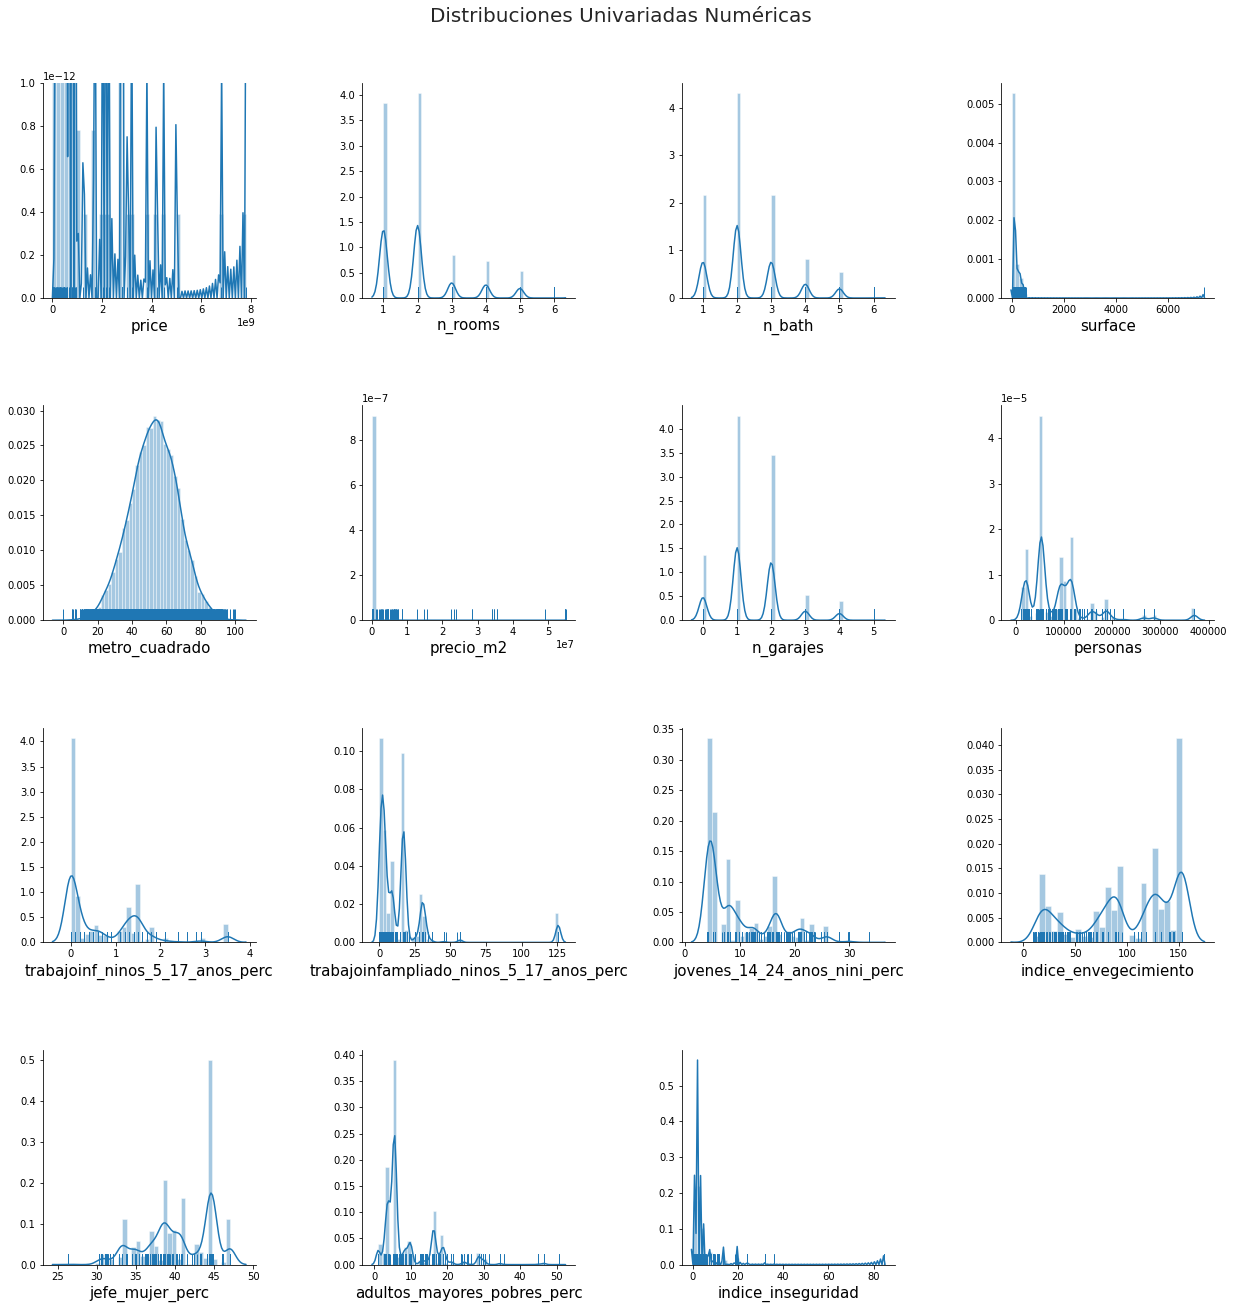

In [31]:
# Grilla de subplots
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[17, 17])
estilo()

# Se remueven el ultimo plot
list(map(lambda a : a.remove(), ax[-1,-1:]))

# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Numéricas',
             fontsize=20,
             x=0.5,
             y=1.05)
'''
Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
distinto en funcion del tipo de dato.

'''
for axis, col in zip(ax.flatten(), numeric):
    print(col)
    try :
        # Graficos para datos numericos
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True)
               
    except RuntimeError:
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True, kde=False)
    
    axis.set_xlabel(col, fontsize=15)

# Se ajusta el espaciado interno entre subplots
w, h = (.5, 0.5)
plt.subplots_adjust(wspace=w, hspace=h)
plt.show()

In [34]:
# Datos faltantes
import missingno as msno
df.replace('nan',np.nan,inplace=True)
print('Valores nan')
print(df.isnull().sum())
print('Mayor info perdida')
print(df.isnull().sum().nlargest(10))

Valores nan
numeric      price                                         0
             n_rooms                                       0
             n_bath                                        0
             surface                                       0
             metro_cuadrado                                0
             precio_m2                                    16
             n_garajes                                     0
             personas                                   1329
             trabajoinf_ninos_5_17_anos_perc            1329
             trabajoinfampliado_ninos_5_17_anos_perc    1329
             jovenes_14_24_anos_nini_perc               1329
             indice_envegecimiento                      1329
             jefe_mujer_perc                            1329
             adultos_mayores_pobres_perc                1329
             indice_inseguridad                         1329
             areas_verdes_perc                          1329
categorical 

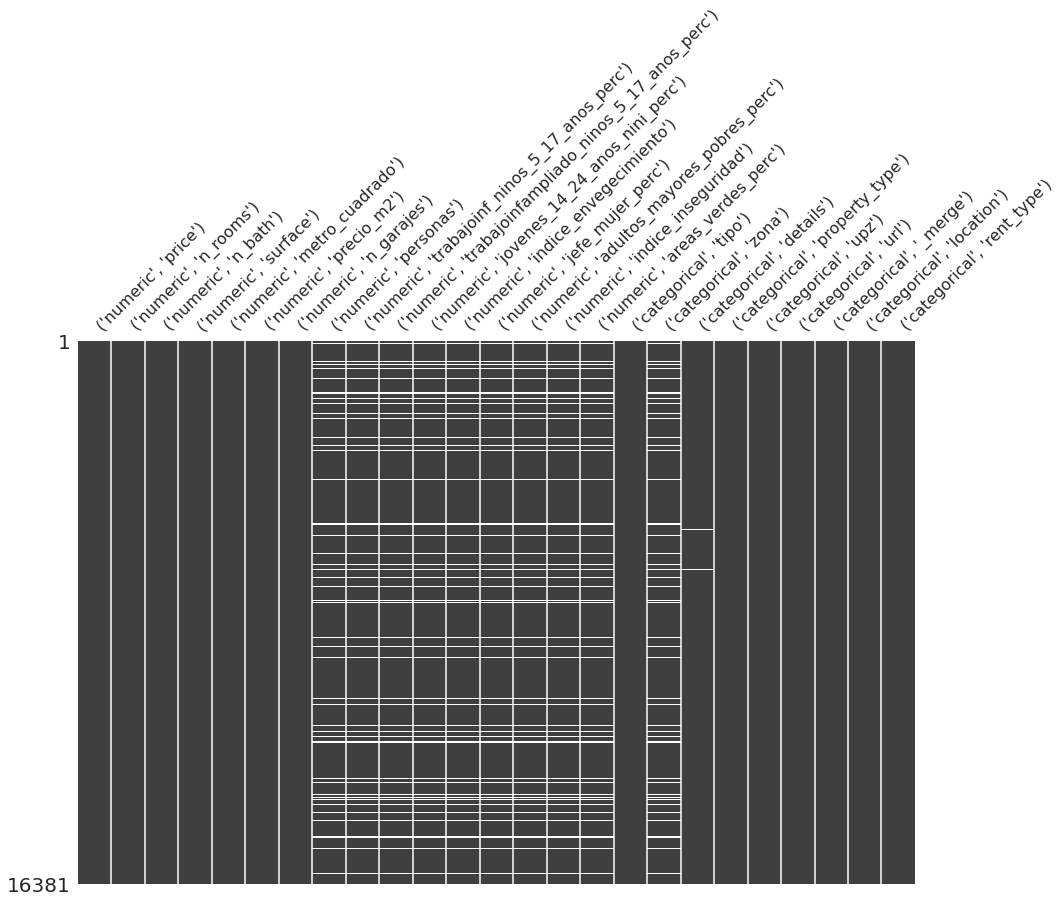

In [35]:
fig, ax = plt.subplots(figsize = [15, 10])
msno.matrix(df,ax = ax, sparkline=False)

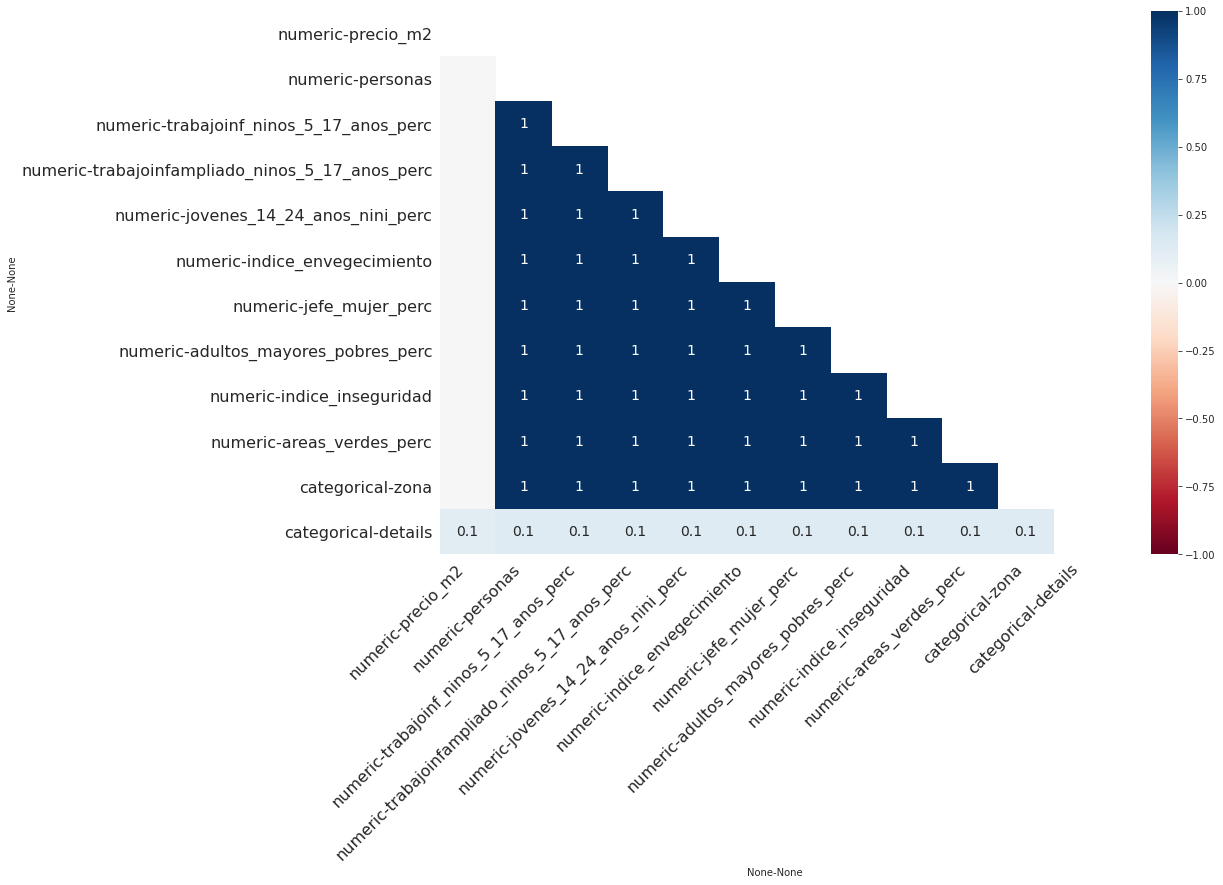

In [36]:
# Correlaciones de nulidad entre pares de variables
fig, ax = plt.subplots(figsize = [15, 10])
msno.heatmap(df, ax = ax)

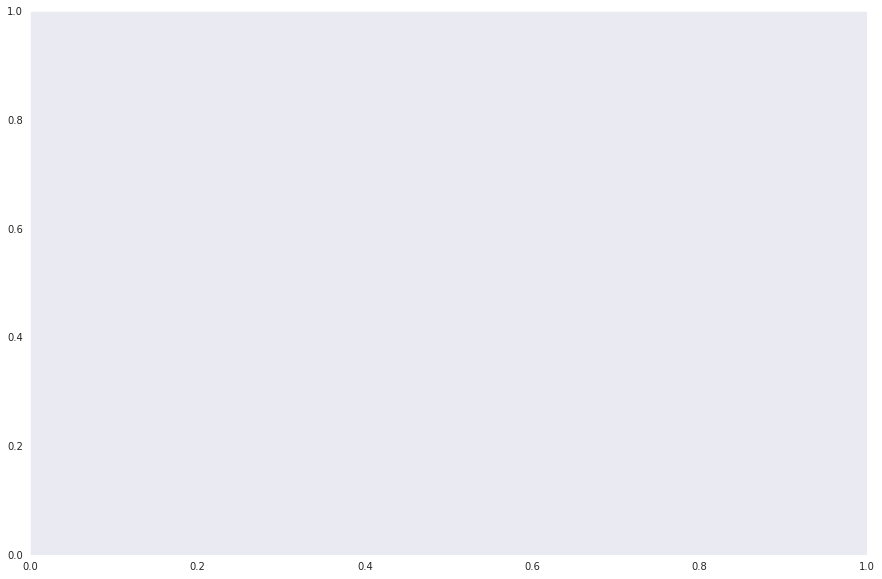

In [37]:
# dropear no mas
df1=df.copy()
df1.dropna(inplace=True)
fig, ax = plt.subplots(figsize = [15, 10])


In [38]:
# dropear precio cero
df1.drop(df1.loc[df1.numeric.precio_m2==0].index)

numeric                                                      \
           price n_rooms n_bath surface metro_cuadrado     precio_m2   
0      1050000.0     3.0    2.0    63.0           25.6  16666.666667   
2       750000.0     3.0    1.0    90.0           12.2   8333.333333   
3      3400000.0     5.0    4.0    71.0           56.0  47887.323944   
4      1560000.0     4.0    3.0    96.0           47.1  16250.000000   
5      1100000.0     3.0    2.0    69.0           32.4  15942.028986   
...          ...     ...    ...     ...            ...           ...   
16376  2600000.0     1.0    2.0    60.0           63.4  43333.333333   
16377  2350000.0     1.0    1.0    43.0           56.0  54651.162791   
16378  1750000.0     1.0    1.0    48.0           39.4  36458.333333   
16379  3900000.0     2.0    3.0   102.0           51.6  38235.294118   
16380  2525000.0     2.0    3.0   106.0           44.4  23820.754717   

                                                           \
      n_garajes  personas trabajoinf_ninos_5_17_anos_perc   
0           1.0   19451.0                             0.6   
2           0.0  179732.0                             0.4   
3           0.0  156375.0                             1.1   
4           1.0   50037.0                             1.8   
5           0.0  158990.0                             0.4   
...         ...       ...                             ...   
16376       1.0  188751.0                             1.2   
16377       1.0   22440.0                             0.2   
16378       1.0   52951.0                             0.0   
16379       2.0   52951.0                             0.0   
16380       2.0  115124.0                             1.5   

                                               ...                    \
      trabajoinfampliado_ninos_5_17_anos_perc  ... areas_verdes_perc   
0                                        18.4  ...          6.563105   
2                                         1.2  ...         21.756250   
3                                         0.8  ...         37.852289   
4                                        16.7  ...         32.395663   
5                                         1.8  ...         45.096719   
...                                       ...  ...               ...   
16376                                     3.9  ...         35.622693   
16377                                     9.3  ...         18.205454   
16378                                    17.0  ...         20.901367   
16379                                    17.0  ...         20.901367   
16380                                     2.0  ...         25.466350   

      categorical                  \
             tipo            zona   
0              -1     Teusaquillo   
2               1        Fontibón   
3              -1  Minuto de Dios   
4               1         Toberin   
5              -1            Suba   
...           ...             ...   
16376          -1  Ismael Perdomo   
16377           6   La Candelaria   
16378           6      Chico Lago   
16379           8      Chico Lago   
16380           8   Santa Barbara   

                                                                        \
                                                 details property_type   
0      Excelente casa cerca de la calle 80 y Avenida ...          Casa   
2      CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...          Casa   
3      casa ezquinera excelente ubicacion cinco alcob...          Casa   
4      Excelente casa de tres niveles, buena ubicació...          Casa   
5      Casa en conjunto cerrado, recién remodelada, c...          Casa   
...                                                  ...           ...   
16376  Se arrienda precioso apartamento amoblado, con...   Apartamento   
16377  CÓMODO APARTAMENTO EN ARRIENDO UBICADO EN EL B...   Apartamento   
16378  Apartamentototalmente  amoblado de 47 metros c...   Apartamento   
16379  Hermoso y acogedor apartamento complet

In [39]:
# Eliminar filas con datos faltantes
df1=df.copy()
df1.dropna(inplace=True)
df1

numeric                                                      \
           price n_rooms n_bath surface metro_cuadrado     precio_m2   
0      1050000.0     3.0    2.0    63.0           25.6  16666.666667   
2       750000.0     3.0    1.0    90.0           12.2   8333.333333   
3      3400000.0     5.0    4.0    71.0           56.0  47887.323944   
4      1560000.0     4.0    3.0    96.0           47.1  16250.000000   
5      1100000.0     3.0    2.0    69.0           32.4  15942.028986   
...          ...     ...    ...     ...            ...           ...   
16376  2600000.0     1.0    2.0    60.0           63.4  43333.333333   
16377  2350000.0     1.0    1.0    43.0           56.0  54651.162791   
16378  1750000.0     1.0    1.0    48.0           39.4  36458.333333   
16379  3900000.0     2.0    3.0   102.0           51.6  38235.294118   
16380  2525000.0     2.0    3.0   106.0           44.4  23820.754717   

                                                           \
      n_garajes  personas trabajoinf_ninos_5_17_anos_perc   
0           1.0   19451.0                             0.6   
2           0.0  179732.0                             0.4   
3           0.0  156375.0                             1.1   
4           1.0   50037.0                             1.8   
5           0.0  158990.0                             0.4   
...         ...       ...                             ...   
16376       1.0  188751.0                             1.2   
16377       1.0   22440.0                             0.2   
16378       1.0   52951.0                             0.0   
16379       2.0   52951.0                             0.0   
16380       2.0  115124.0                             1.5   

                                               ...                    \
      trabajoinfampliado_ninos_5_17_anos_perc  ... areas_verdes_perc   
0                                        18.4  ...          6.563105   
2                                         1.2  ...         21.756250   
3                                         0.8  ...         37.852289   
4                                        16.7  ...         32.395663   
5                                         1.8  ...         45.096719   
...                                       ...  ...               ...   
16376                                     3.9  ...         35.622693   
16377                                     9.3  ...         18.205454   
16378                                    17.0  ...         20.901367   
16379                                    17.0  ...         20.901367   
16380                                     2.0  ...         25.466350   

      categorical                  \
             tipo            zona   
0              -1     Teusaquillo   
2               1        Fontibón   
3              -1  Minuto de Dios   
4               1         Toberin   
5              -1            Suba   
...           ...             ...   
16376          -1  Ismael Perdomo   
16377           6   La Candelaria   
16378           6      Chico Lago   
16379           8      Chico Lago   
16380           8   Santa Barbara   

                                                                        \
                                                 details property_type   
0      Excelente casa cerca de la calle 80 y Avenida ...          Casa   
2      CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...          Casa   
3      casa ezquinera excelente ubicacion cinco alcob...          Casa   
4      Excelente casa de tres niveles, buena ubicació...          Casa   
5      Casa en conjunto cerrado, recién remodelada, c...          Casa   
...                                                  ...           ...   
16376  Se arrienda precioso apartamento amoblado, con...   Apartamento   
16377  CÓMODO APARTAMENTO EN ARRIENDO UBICADO EN EL B...   Apartamento   
16378  Apartamentototalmente  amoblado de 47 metros c...   Apartamento   
16379  Hermoso y acogedor apartamento complet

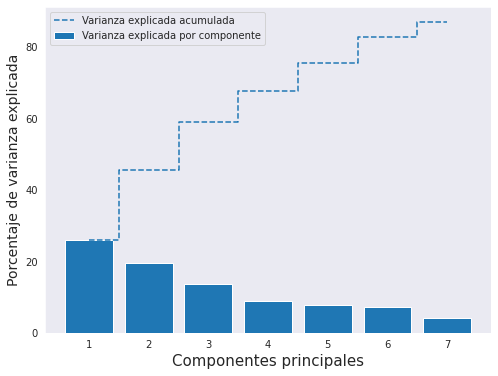

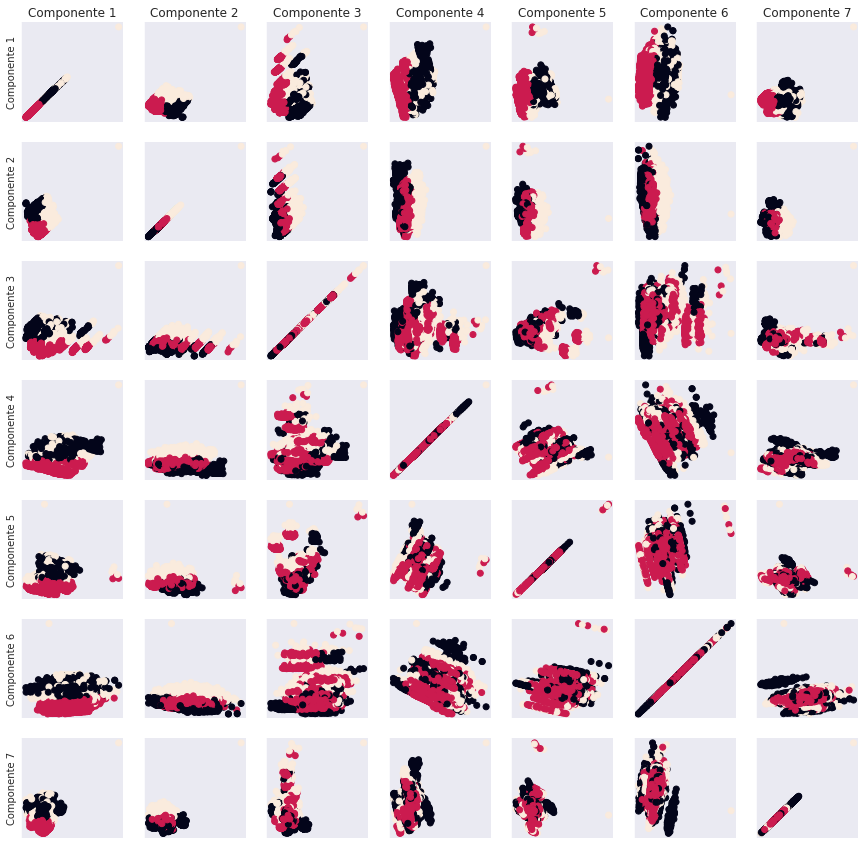

In [40]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
df_1=scaler.fit_transform(df1['numeric'].drop(columns=['price','precio_m2']))


n_com=7
pca=PCA(n_components=n_com)
pecea=pca.fit_transform(df_1)
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
cum_var_exp = np.cumsum(per_var)
plt.rcParams["figure.figsize"] = [8.0, 6.0]
#the following code makes a fancy looking plot using PC1 and PC2
plt.bar(x=range(1,len(per_var)+1), height=per_var,label='Varianza explicada por componente')
plt.step(np.arange(n_com)+1, cum_var_exp, where='mid', linestyle='--', label='Varianza explicada acumulada')
plt.ylabel('Porcentaje de varianza explicada',fontsize=14)
plt.xlabel('Componentes principales',fontsize=15)
plt.legend(loc='best')
plt.show()


n_clu=3
kmeans=KMeans(n_clusters=n_clu).fit_predict(pecea)


fig, axes =plt.subplots(n_com,n_com,figsize=(15,15))
fig.suptitle('')

for i in range(n_com):
    for j in range(n_com):
        axes[i,j].scatter(pecea[:,i],pecea[:,j],c=kmeans)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        estilo()
        if i==0:
            axes[i,j].set_title('Componente '+str(j+1))
        if j==0:
            axes[i,j].set(ylabel='Componente '+str(i+1))

plt.show()





In [41]:
# Evaluar como se distribuyen los upz's en esos clusters
# cuantos hay
print('hay ',len(df1.categorical.upz.unique()),' diferentes upz')
#agregar cluster
#df1.loc['categorical','upz_cluster']=kmeans
print(df1.shape)
print(kmeans.shape)

df1[('categorical','upz_cluster')]=kmeans

hay  100  diferentes upz
(14987, 25)
(14987,)


In [42]:
upz_assignment={upz : 0 for upz in df1.categorical.upz.unique()}
for upz in df1.categorical.upz.unique():
    cluster_aparition=[]
    for k in np.arange(n_clu):
        s=sum((df1.categorical.upz==upz) & (df1.categorical.upz_cluster==k))
        cluster_aparition.append(s)
    upz_assignment[upz]=cluster_aparition.index(max(cluster_aparition))
    
column=[]
for upz in df1.categorical.upz:
    column.append(upz_assignment[upz])
df1[('categorical','upz_group')]=column

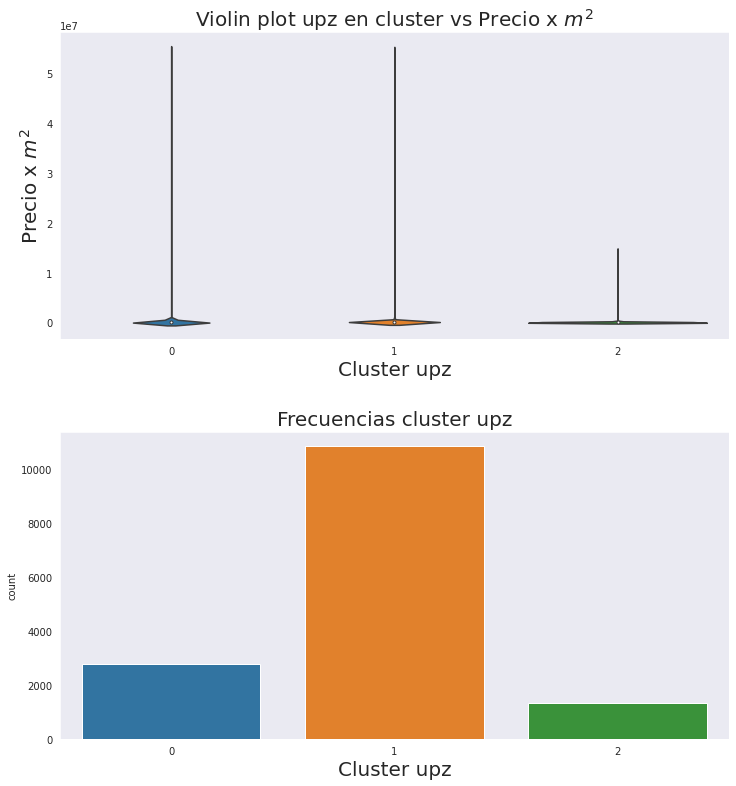

In [43]:
def violin_and_frec_plot(categorical_variable,title1,title2):
    fontdict = {'fontsize':20}
    fig, ax = plt.subplots(2,1,figsize=[12,13])
    sns.violinplot(('categorical', categorical_variable),
                y=('numeric', 'precio_m2'),
                data=df1,
                kind='violin',
                ax=ax[0])
    sns.countplot(df1[('categorical',categorical_variable)], ax=ax[1])
    ax[0].set_xlabel('Cluster upz', fontdict)
    ax[1].set_xlabel('Cluster upz', fontdict)
    #ax[0].set_ylim(0,1000000)
    ax[0].set_ylabel(r'Precio x $m^2$', fontdict)
    ax[0].set_title(title1, fontdict)
    ax[1].set_title(title2, fontdict)
    h, w = (.3, .1)
    plt.subplots_adjust(wspace=w, hspace=h)
    
violin_and_frec_plot('upz_group','Violin plot upz en cluster vs Precio x $m^2$','Frecuencias cluster upz')

ValueError: Can only tuple-index with a MultiIndex

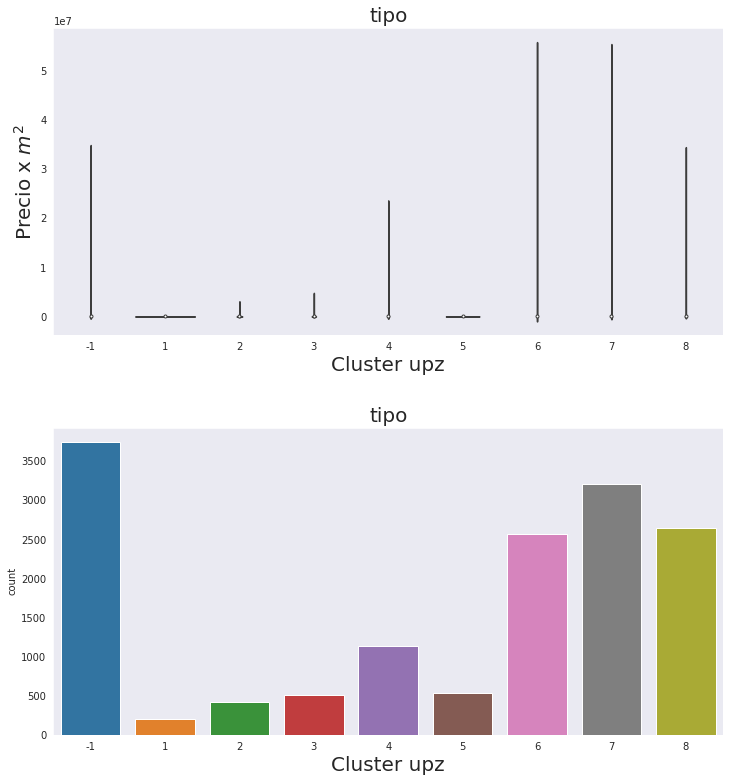

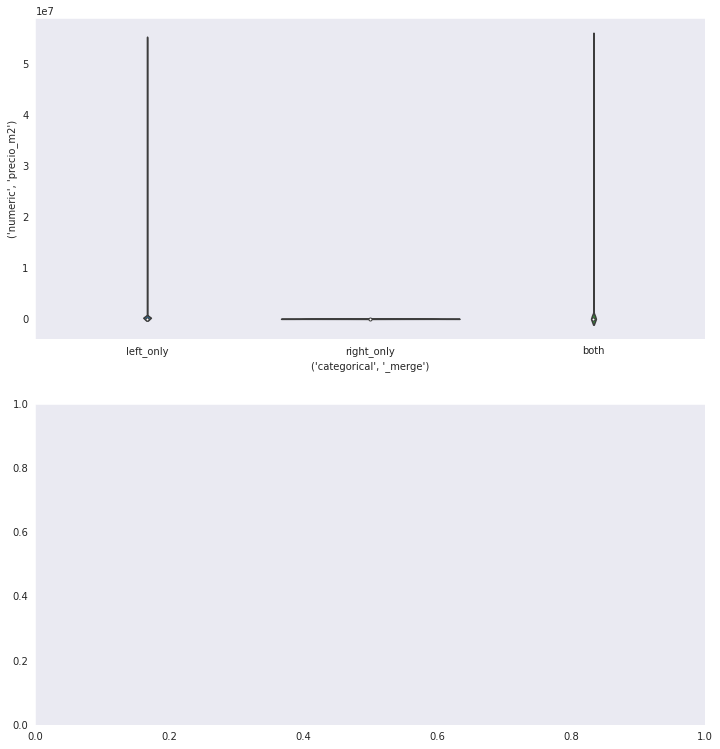

In [47]:
violin_and_frec_plot('tipo','tipo','tipo')
violin_and_frec_plot('_merge','merge','merge')
violin_and_frec_plot('property_type','inmueble','inmueble')
violin_and_frec_plot('zona','zona','zona')

In [48]:
def scatter_dists(col, df=df1, h=.3, w=.1, fontdict={'fontsize': 20}, reg=True):
    ''' Recibe una columna numerica y genera una visualizacion comparativa.
    
    Genera una figura por sobre el dataframe HousePricing (por defecto), recibe 
    parametros extra como el espaciado entre subfigura.
    
    Args:
    ----------
    
    col: String
         El nombre de la columna numerica a visualizar
    
    h,w: float
        Espaciado entre subplot h -> vertical, w -> horizontal
    
    fontdict: dict
             Permite configurar las fuentes de los subplots
    reg: bool
         Permite graficar una regresion lineal sobre los datos (if True)
        
    Returns: None
        Se muestra una figura en pantalla    
    
    '''
    fig, ax = plt.subplots(2, 1, figsize=[12, 13])
    if reg:
        sns.regplot(x=df[('numeric', col)],
                    y=df[('numeric', 'precio_m2')],
                    ax=ax[0])
        ax[0].set_title(r'Regplot plot {} vs Precio por m^2'.format(col), fontdict)
    else:
        sns.scatterplot(('numeric', col),
                        y=('numeric', 'precio_m2'),
                        data=df,
                        ax=ax[0])
        ax[0].set_title(r'Scatter plot {} vs Precio por m^2'.format(col), fontdict)

    
    # Distribucion univariada
    sns.distplot(df[('numeric', col)], ax=ax[1])
    ax[0].set_ylim(0,100000)
    ax[0].set_xlabel(col, fontdict)
    ax[1].set_xlabel(col, fontdict)

    ax[0].set_ylabel('Precio por m^2', fontdict)
    ax[1].set_title('Frecuencias {}'.format(col), fontdict)

    plt.subplots_adjust(wspace=w, hspace=h)


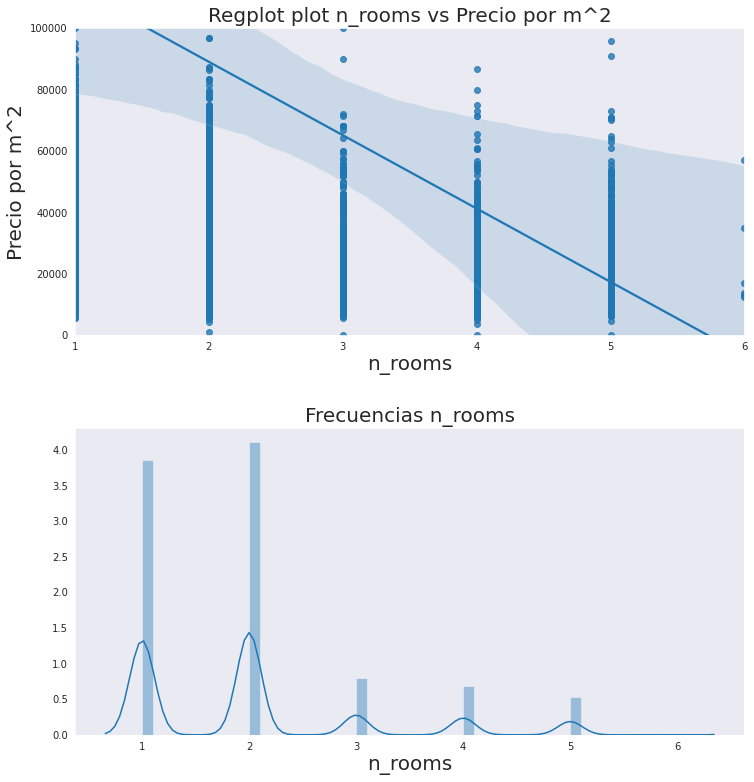

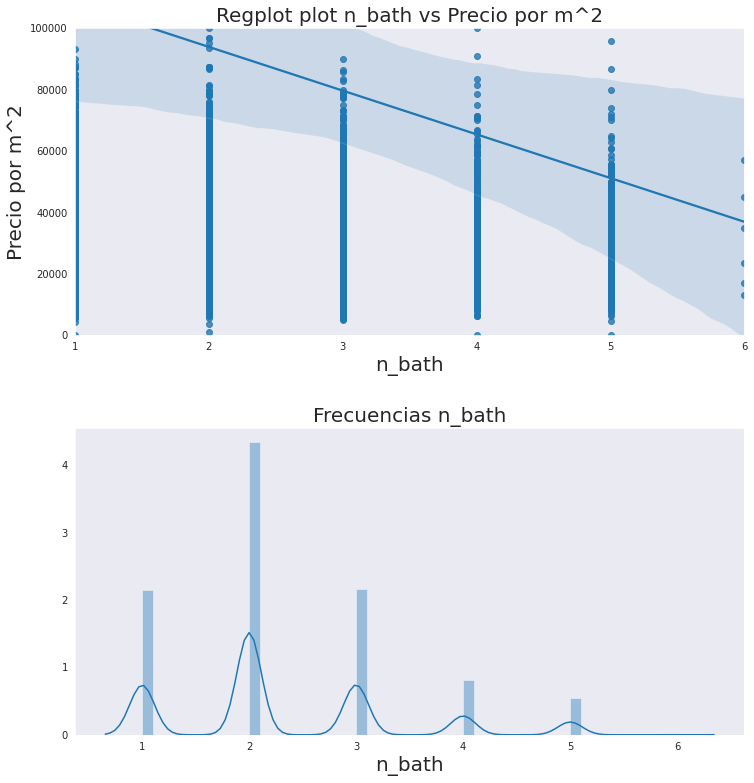

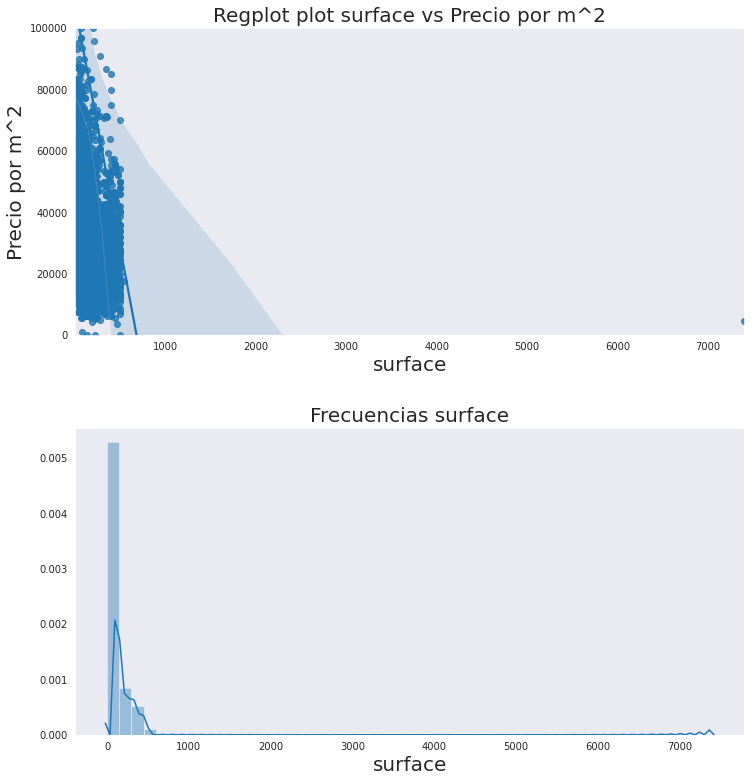

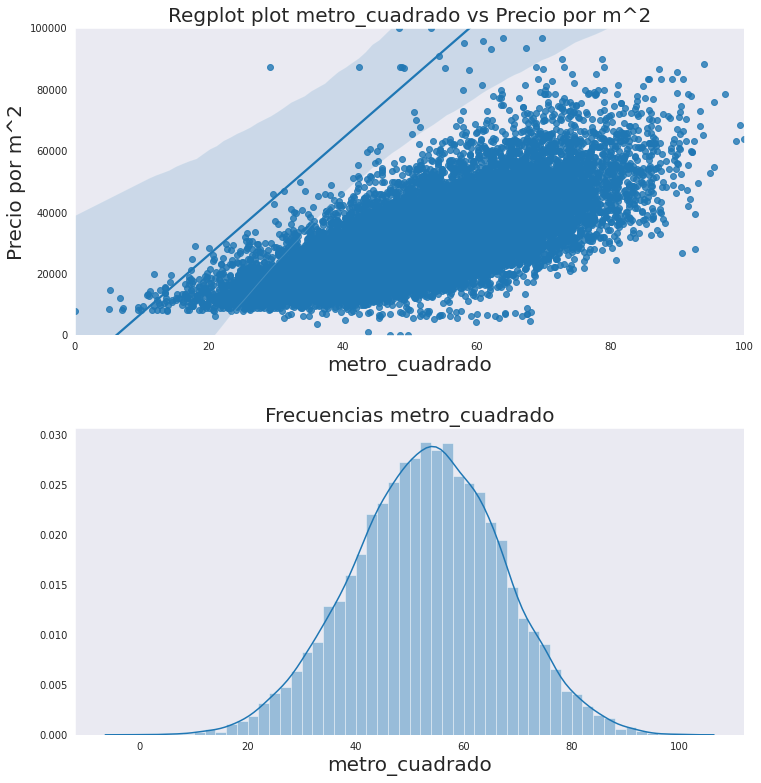

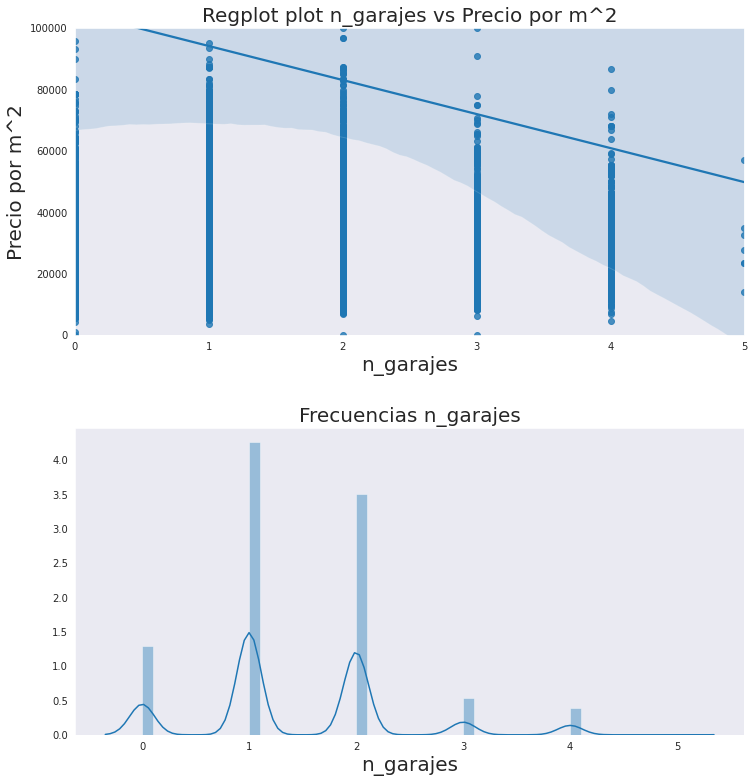

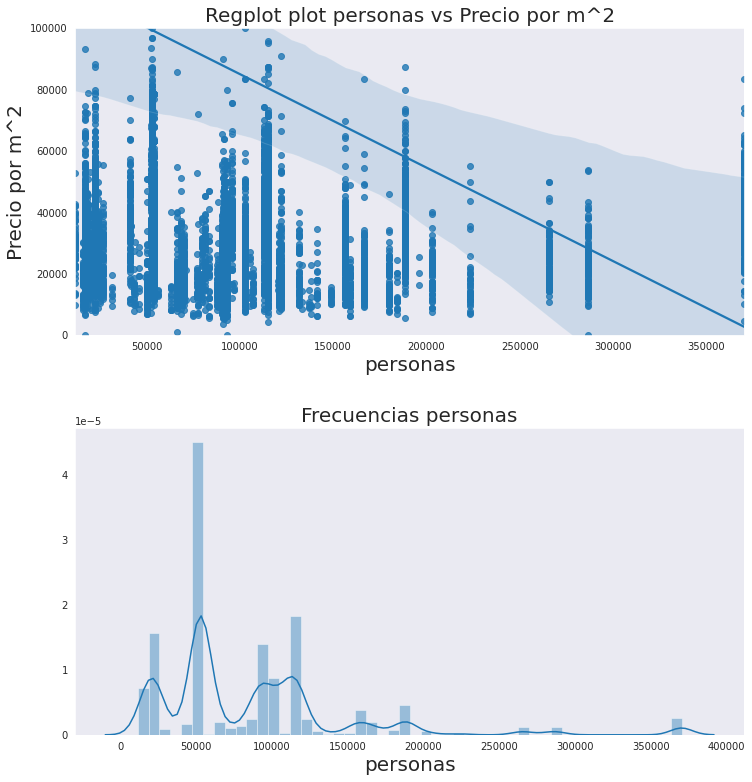

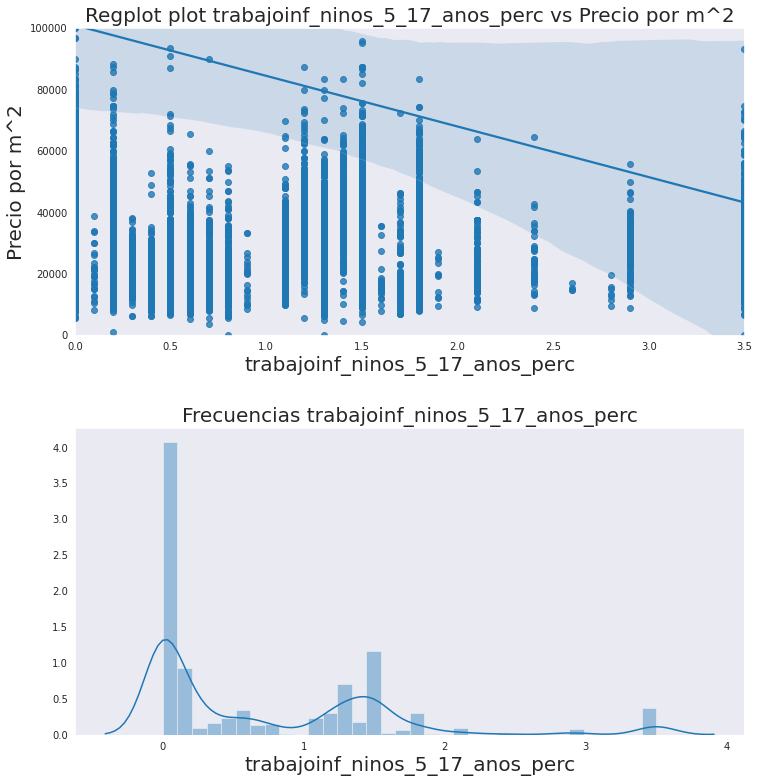

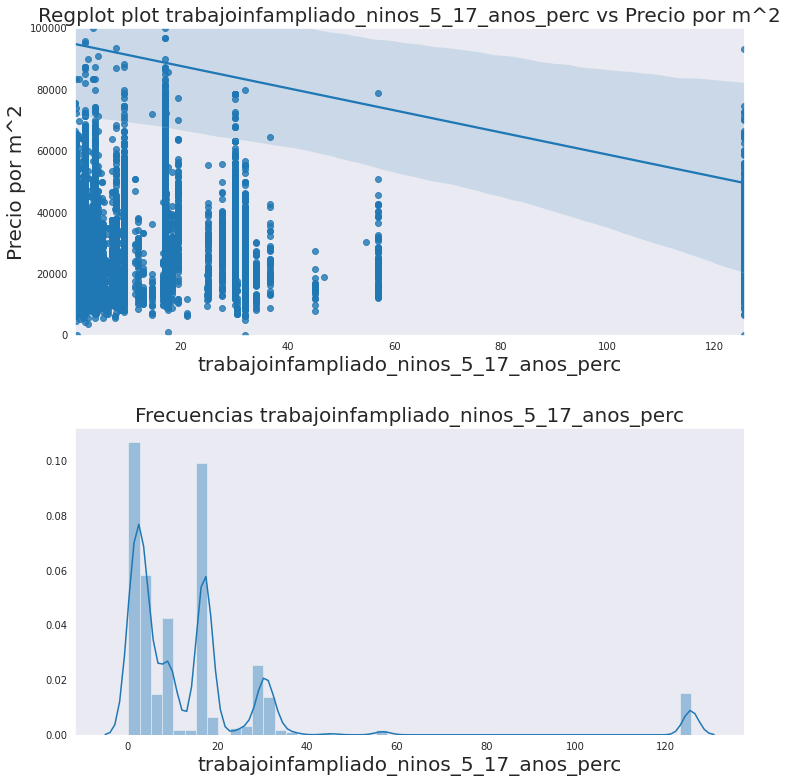

In [49]:
scatter_dists('n_rooms')
scatter_dists('n_bath')
scatter_dists('surface')
scatter_dists('metro_cuadrado')
scatter_dists('n_garajes')
scatter_dists('personas')
scatter_dists('trabajoinf_ninos_5_17_anos_perc')
scatter_dists('trabajoinfampliado_ninos_5_17_anos_perc')

In [50]:
df1

numeric                                                      \
           price n_rooms n_bath surface metro_cuadrado     precio_m2   
0      1050000.0     3.0    2.0    63.0           25.6  16666.666667   
2       750000.0     3.0    1.0    90.0           12.2   8333.333333   
3      3400000.0     5.0    4.0    71.0           56.0  47887.323944   
4      1560000.0     4.0    3.0    96.0           47.1  16250.000000   
5      1100000.0     3.0    2.0    69.0           32.4  15942.028986   
...          ...     ...    ...     ...            ...           ...   
16376  2600000.0     1.0    2.0    60.0           63.4  43333.333333   
16377  2350000.0     1.0    1.0    43.0           56.0  54651.162791   
16378  1750000.0     1.0    1.0    48.0           39.4  36458.333333   
16379  3900000.0     2.0    3.0   102.0           51.6  38235.294118   
16380  2525000.0     2.0    3.0   106.0           44.4  23820.754717   

                                                           \
      n_garajes  personas trabajoinf_ninos_5_17_anos_perc   
0           1.0   19451.0                             0.6   
2           0.0  179732.0                             0.4   
3           0.0  156375.0                             1.1   
4           1.0   50037.0                             1.8   
5           0.0  158990.0                             0.4   
...         ...       ...                             ...   
16376       1.0  188751.0                             1.2   
16377       1.0   22440.0                             0.2   
16378       1.0   52951.0                             0.0   
16379       2.0   52951.0                             0.0   
16380       2.0  115124.0                             1.5   

                                               ...     categorical  \
      trabajoinfampliado_ninos_5_17_anos_perc  ...            zona   
0                                        18.4  ...     Teusaquillo   
2                                         1.2  ...        Fontibón   
3                                         0.8  ...  Minuto de Dios   
4                                        16.7  ...         Toberin   
5                                         1.8  ...            Suba   
...                                       ...  ...             ...   
16376                                     3.9  ...  Ismael Perdomo   
16377                                     9.3  ...   La Candelaria   
16378                                    17.0  ...      Chico Lago   
16379                                    17.0  ...      Chico Lago   
16380                                     2.0  ...   Santa Barbara   

                                                                        \
                                                 details property_type   
0      Excelente casa cerca de la calle 80 y Avenida ...          Casa   
2      CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...          Casa   
3      casa ezquinera excelente ubicacion cinco alcob...          Casa   
4      Excelente casa de tres niveles, buena ubicació...          Casa   
5      Casa en conjunto cerrado, recién remodelada, c...          Casa   
...                                                  ...           ...   
16376  Se arrienda precioso apartamento amoblado, con...   Apartamento   
16377  CÓMODO APARTAMENTO EN ARRIENDO UBICADO EN EL B...   Apartamento   
16378  Apartamentototalmente  amoblado de 47 metros c...   Apartamento   
16379  Hermoso y acogedor apartamento completamente a...   Apartamento   
16380  Hermoso apartamento de 106m2  2  añoS de const...   Apartamento   

                                                                              \
          upz                                                url      _merge   
0      UPZ101  https://www.metrocuadrado.com/inmueble/arriend...   left_only   
2       UPZ75  https://www.metrocuadrado.com/inmueble/arriend...   left_only   
3       UPZ29  https://www.metrocuadrado.com/inmueble/arriend...   left_only   
4   

In [51]:
# Perfilamiento Bivariado
# Se genera una función auxiliar
def indexer(cols, t_c = df1.columns):
        '''Genera columnas multinivel a partir de nombres de columna planos.'''

        set_to_tuple = set(*[cols])

        tuples = [
            i for i in t_c if set_to_tuple.intersection(set(i))
        ]
        return tuples
def perfil_bivariado(interest):
    # Variables a examinar
    idxs = indexer(interest)
    df1[idxs].head()
    # Pone precio_m2 al final de la lista
    idxs.sort()
    idxs.remove(('numeric', 'precio_m2'))
    idxs.append(('numeric', 'precio_m2'))
    # para que Seaborn entienda
    data = df1.reindex(idxs, axis=1).droplevel(0,axis=1)
    # quitar 100 datos con precio mas grande para poder visualizar mejor
    data.drop(data.precio_m2.nlargest(100).index)

    sns.pairplot(data = data, diag_kind='kde')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


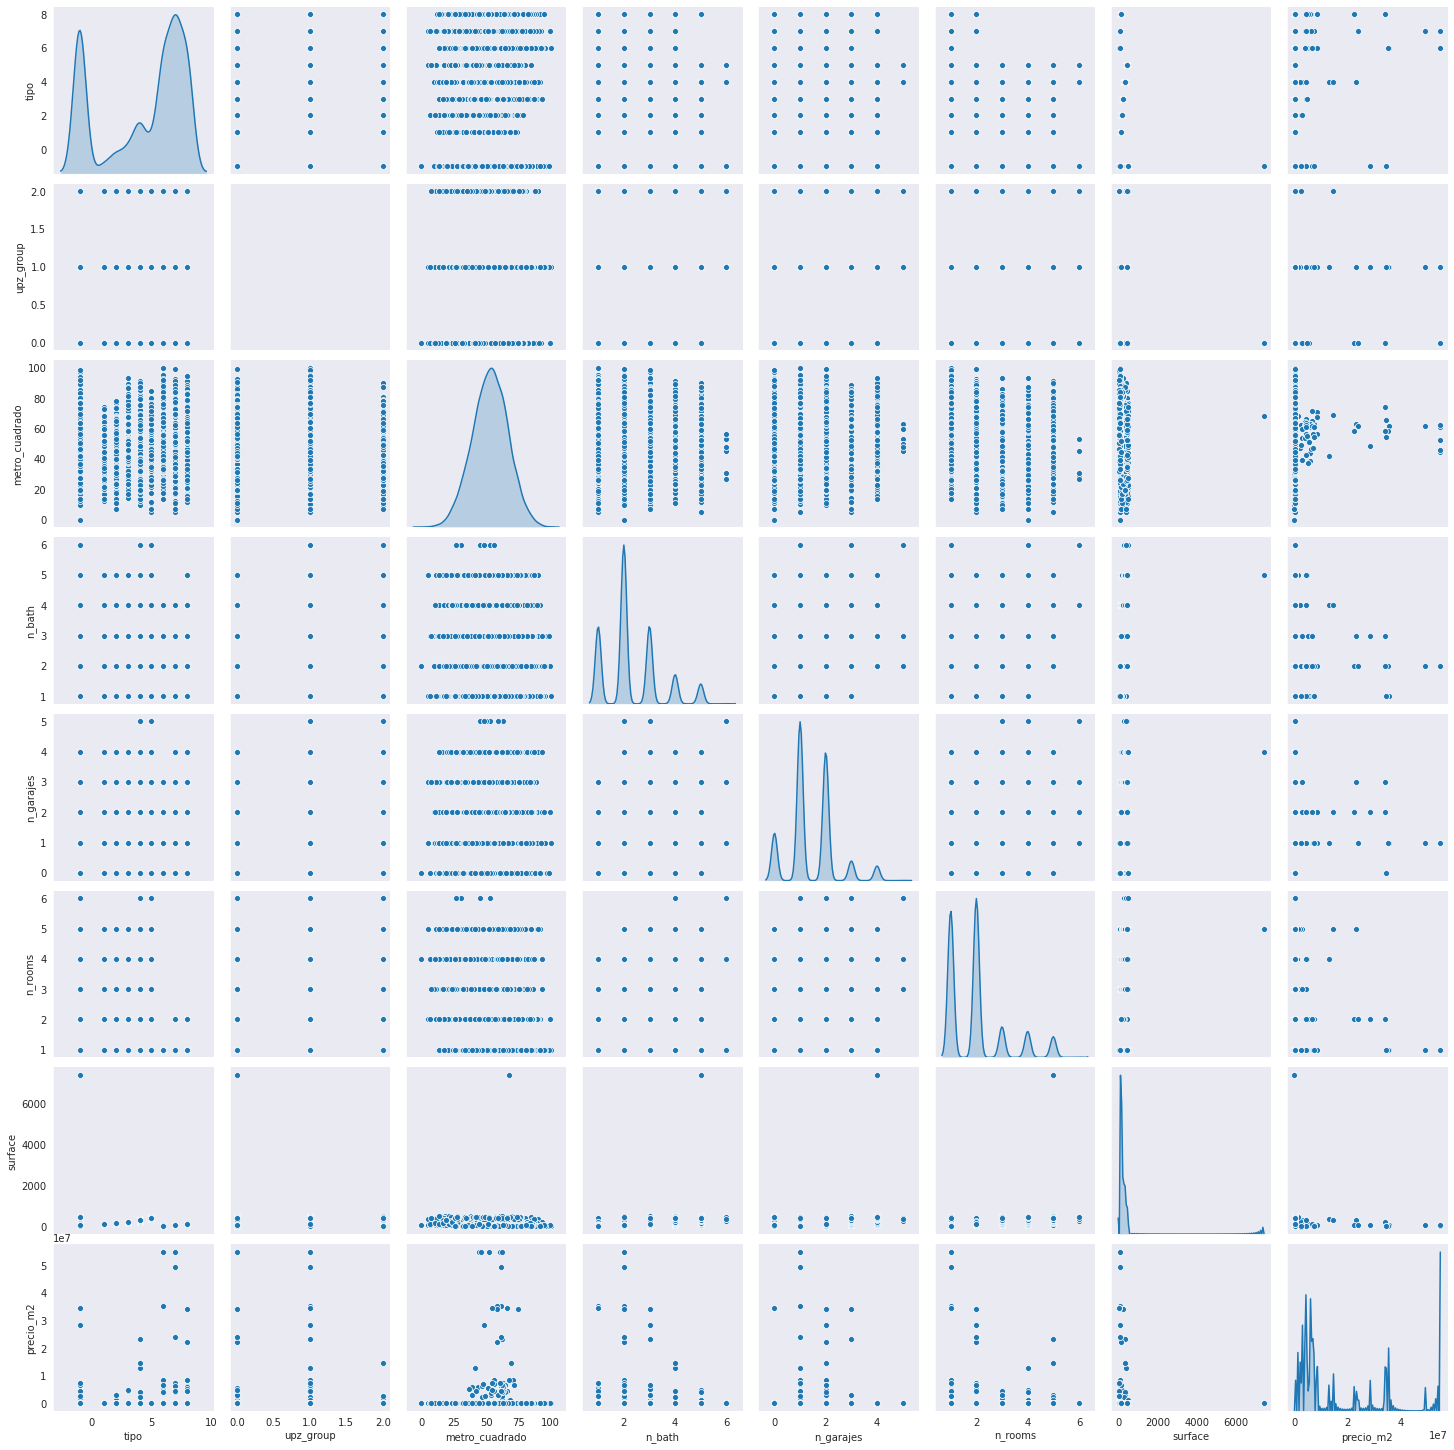

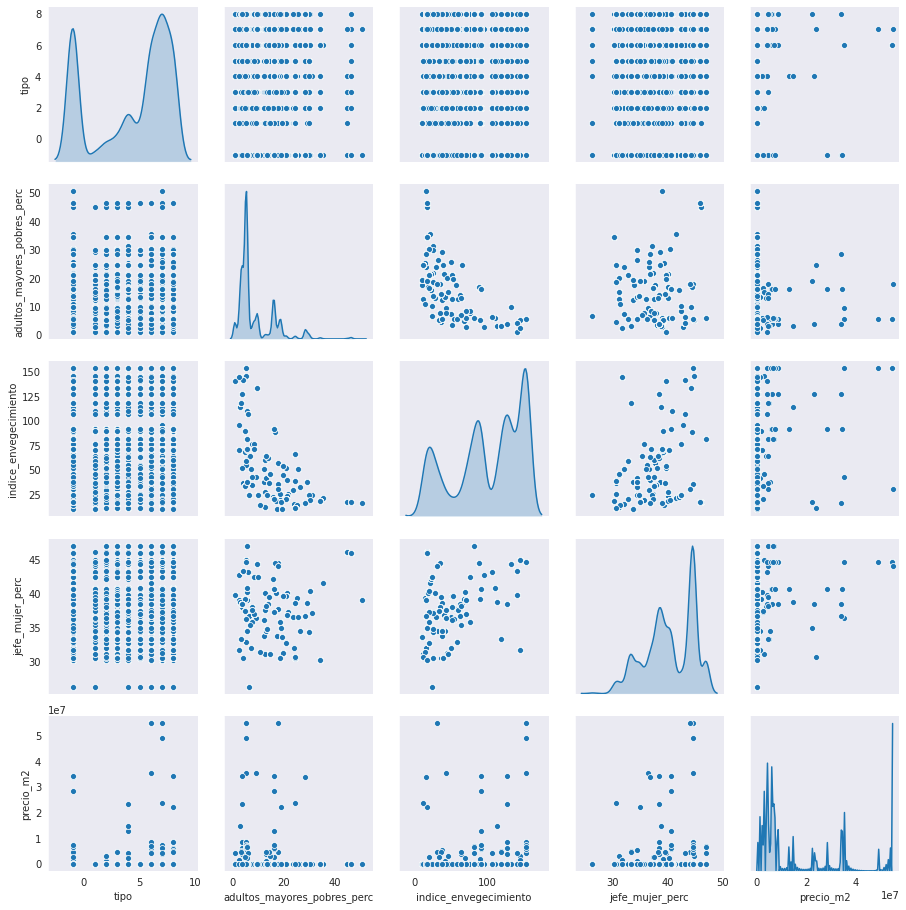

In [52]:
interest1=['precio_m2', 'n_rooms', 'n_bath', 'surface', 'n_garajes','property_type', 'upz_group','tipo','metro_cuadrado']
perfil_bivariado(interest1)
interest2=['precio_m2','jefe_mujer_perc','indice_envegecimiento','adultos_mayores_pobres_perc','tipo']
perfil_bivariado(interest2)

10 variables más correlacionadas
                                           numeric
                                         precio_m2
numeric     precio_m2                     1.000000
            price                         0.767205
            metro_cuadrado                0.018871
            jefe_mujer_perc               0.013570
            indice_envegecimiento         0.007868
            adultos_mayores_pobres_perc   0.007280
categorical tipo                          0.004432
numeric     jovenes_14_24_anos_nini_perc  0.001579
categorical upz_group                    -0.005848
numeric     indice_inseguridad           -0.006324
3 variables menos correlacionadas
                   numeric
                 precio_m2
numeric n_rooms  -0.019166
        personas -0.014241
        surface  -0.013268


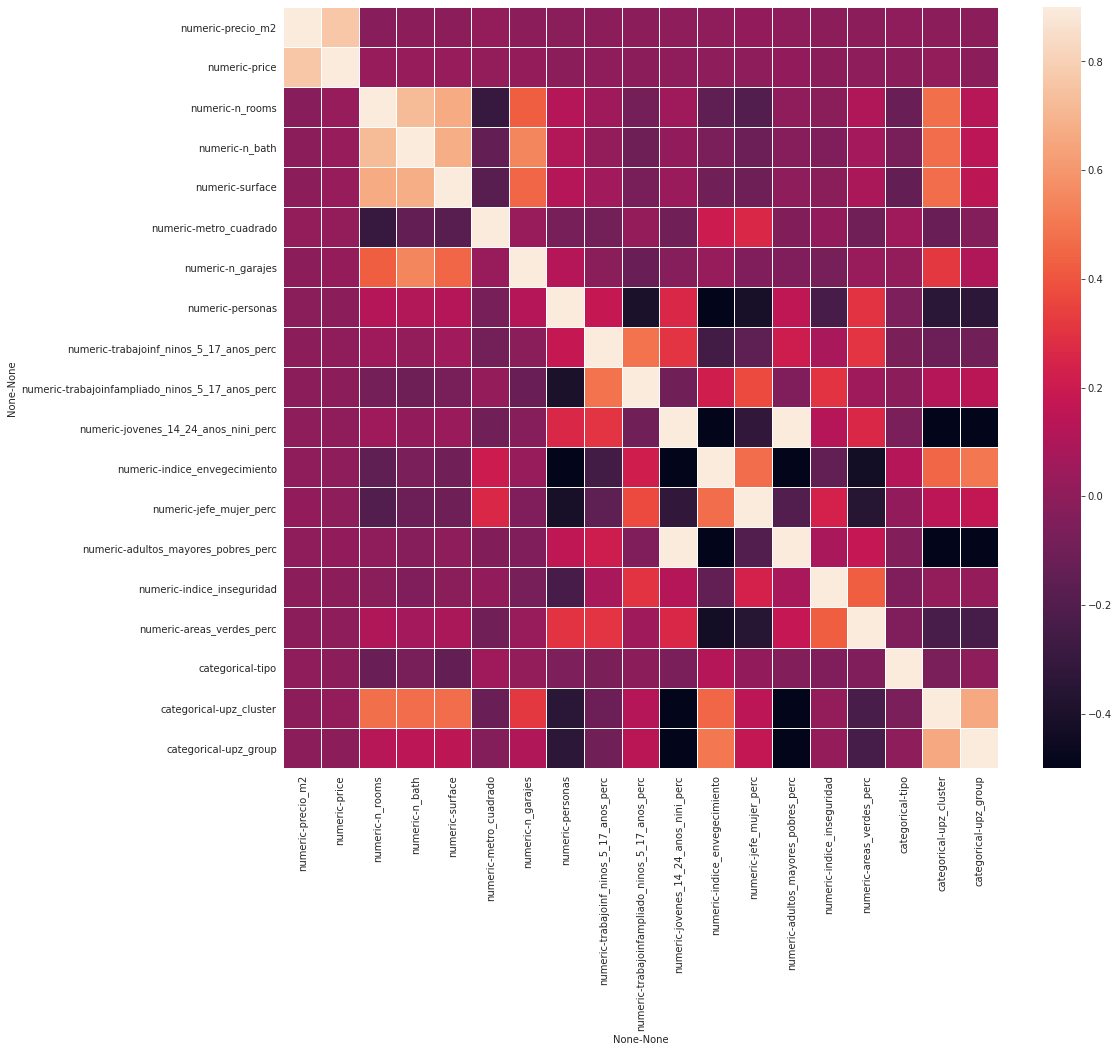

In [53]:
# matriz de correlaciones
corr_matrix=df1.corr()
col = indexer(['precio_m2'])
print('10 variables más correlacionadas')
print(corr_matrix[col].nlargest(10,col))
print('3 variables menos correlacionadas')
print(corr_matrix[col].nsmallest(3,col))


# Visualizar

'''
Se inserta 'precio_m2' como primera fila x columna de la matriz de correlacion
'''

unsorted = list(corr_matrix.columns)
unsorted.remove(*col)
unsorted.insert(0, *col)

sortd = pd.MultiIndex.from_tuples(unsorted)
corrmat = corr_matrix.reindex(index = sortd, columns = sortd)
'''
Dado lo anterior, se ajusta el anchor de colores con maximo en .9
y -0.5, para tener una perspectiva entorno a los valores maximos 
de correlacion (negativa y positiva)
'''

fig, ax = plt.subplots(figsize=[16, 14])

sns.heatmap(corrmat, vmin=-.5, vmax=.9, linewidths=.01)

In [54]:
# analisis categórico versus categóricos

data_cat = df1['categorical']
def categorical_compa(cat1,cat2):
    to_compare=[cat1,cat2]
    kwargs = {'index': data_cat[to_compare[0]], 'columns': data_cat[to_compare[1]]}
    tabla = pd.crosstab(**kwargs, margins=True, margins_name='Total')
    return tabla

In [55]:
categorical_compa('rent_type','property_type')

property_type,Apartamento,Casa,Total
rent_type,,,
Arriendo,10244,2588,12832
Venta Y Arriendo,1406,749,2155
Total,11650,3337,14987


In [56]:
categorical_compa('rent_type','tipo')

tipo,-1,1,2,3,4,5,6,7,8,Total
rent_type,,,,,,,,,,
Arriendo,3313,194,365,394,828,383,2334,2816,2205,12832
Venta Y Arriendo,432,12,57,117,308,147,241,394,447,2155
Total,3745,206,422,511,1136,530,2575,3210,2652,14987


In [57]:
categorical_compa('tipo','zona')

zona,20 de Julio,Alamos,Alfonso López,Américas,Apogeo,Arborizadora,Bavaria,Bolivia,Bosa Central,Bosa Occidental,...,Timiza,Tintal Norte,Tintal Sur,Toberin,Usaquen,Venecia,Verbenal,Zona Franca,Zona Industrial,Total
tipo,,,,,,,,,,,,,,,,,,,,,
-1,7,1,33,9,1,1,52,20,8,9,...,4,4,6,9,115,1,9,3,2,3745
1,4,0,0,5,3,0,1,3,1,0,...,3,0,8,10,5,1,1,0,2,206
2,7,0,2,2,1,2,8,8,9,3,...,2,0,1,6,20,2,0,0,2,422
3,5,0,2,2,0,0,6,8,19,5,...,0,0,0,4,38,0,1,0,0,511
4,0,2,2,1,0,1,91,15,37,6,...,1,1,0,8,67,1,0,0,0,1136
5,0,1,2,0,0,0,30,4,22,0,...,2,0,0,1,45,0,0,0,1,530
6,3,0,5,0,0,0,0,46,10,8,...,1,5,1,0,88,0,5,0,5,2575
7,8,0,1,2,0,0,1,51,21,6,...,6,1,9,14,96,2,5,0,7,3210
8,4,0,2,1,0,0,0,13,4,1,...,0,0,1,3,57,0,0,0,1,2652


In [58]:
categorical_compa('upz_group','tipo')

tipo,-1,1,2,3,4,5,6,7,8,Total
upz_group,,,,,,,,,,
0,828,73,104,121,205,84,407,528,426,2776
1,2608,103,230,289,573,267,2071,2554,2176,10871
2,309,30,88,101,358,179,97,128,50,1340
Total,3745,206,422,511,1136,530,2575,3210,2652,14987


In [59]:
# comparar con test xi^2
from scipy.stats import chi2_contingency
def test_xi(cat1,cat2):
    to_compare=[cat1,cat2]
    kwargs = {'index': data_cat[to_compare[0]], 'columns': data_cat[to_compare[1]]}
    tabla = pd.crosstab(**kwargs, margins=False)
    chi2, p, dof, ex =chi2_contingency(tabla)
    expected_freq = pd.DataFrame(ex, index=df1.categorical[cat1].unique())
    expected_freq.index.name = cat1
    expected_freq.columns.name = cat2
    return p,expected_freq

p, table=test_xi('upz_group','tipo')
print(p)
table

0.0


tipo,0,1,2,3,4,5,6,7,8
upz_group,,,,,,,,,
1,693.675852,38.156803,78.165877,94.651098,210.418096,98.170414,476.960032,594.579302,491.222526
0,2716.480617,149.424568,306.102756,370.659972,824.011210,384.441850,1867.807099,2328.411957,1923.659972
2,334.843531,18.418629,37.731367,45.688930,101.570695,47.387736,230.232868,287.008741,237.117502


In [60]:
p, table=test_xi('rent_type','tipo')
print(p)
table

2.8402746028825574e-75


tipo,0,1,2,3,4,5,6,7,8
rent_type,,,,,,,,,
Arriendo,3206.501635,176.378995,361.320077,437.522653,972.653099,453.790619,2204.737439,2748.429973,2270.66551
Venta Y Arriendo,538.498365,29.621005,60.679923,73.477347,163.346901,76.209381,370.262561,461.570027,381.33449


# P3

### Implementación. 1

In [61]:
from sklearn.base import BaseEstimator, RegressorMixin
from numpy import matmul
from numpy.linalg import pinv, eig
import sys
import time
import numpy as np

class RegresionBayesianaEmpirica(BaseEstimator, RegressorMixin):
    def __init__(self, alpha_0, beta_0, tol=1e-5, maxiter=200):
        self.maxiter = maxiter
        self.tol = tol
        self.alpha_0 = alpha_0
        self.beta_0 = beta_0
        self.alpha = alpha_0
        self.beta = beta_0
        self.M_n = None
        self.S_n = None
        
    
    def get_posteriori(self, X, y, alpha, beta):

        S_n = alpha + beta*matmul(X.T, X)
        M_n = beta * matmul(matmul(pinv(S_n), X.T), y)
        return M_n, S_n
    
    
    def fit(self, X, y):
        X = np.hstack((np.ones((1,X.shape[0])).T , X))
        N = len(y)
        for i in range(self.maxiter):
            t0 = time.time()
            eigen_values, _ = eig(self.beta * matmul(X.T, X))
            gamma = (eigen_values/(self.alpha + eigen_values)).sum()
            M_n, S_n = self.get_posteriori(X, y, self.alpha, self.beta)
            new_alpha = gamma/(matmul(M_n.T, M_n))
            new_beta = (N-gamma)/((y - matmul(M_n.T, X.T))**2).sum() #Revisar X.T
            
            alpha_delta = np.abs(self.alpha - new_alpha)
            beta_delta = np.abs(self.beta - new_beta)
            
            sys.stdout.write(
                      '\rIter:{0:03d}'.format(i) + ' Alpha delta:{0:.5f}'.format(alpha_delta)
                      + ' Beta Delta:{0:.5f}'.format(beta_delta) 
                      + ' Tiempo/iter:{0:.5f}s'.format(time.time()- t0))   
            
            if (alpha_delta > self.tol or beta_delta > self.tol):
                self.alpha = new_alpha
                self.beta = new_beta
            else:
                self.M_n = M_n
                self.S_n = S_n
                break
        self.M_n = M_n
        self.S_n = S_n
                    
    #Predicción utilizando la media posterior predictiva
    def predict(self, X_, return_std = False):
        X_ = np.hstack((np.ones((1,X_.shape[0])).T , X_))
        mu = matmul(self.M_n.T, X_.T)
        if return_std:
            std = np.sqrt(self.beta**-1 + matmul(matmul(X_.T, self.S_n), X_) )
            return mu, std
        else:
            return mu

In [89]:
df1


numeric                                                      \
           price n_rooms n_bath surface metro_cuadrado     precio_m2   
0      1050000.0     3.0    2.0    63.0           25.6  16666.666667   
2       750000.0     3.0    1.0    90.0           12.2   8333.333333   
3      3400000.0     5.0    4.0    71.0           56.0  47887.323944   
4      1560000.0     4.0    3.0    96.0           47.1  16250.000000   
5      1100000.0     3.0    2.0    69.0           32.4  15942.028986   
...          ...     ...    ...     ...            ...           ...   
16376  2600000.0     1.0    2.0    60.0           63.4  43333.333333   
16377  2350000.0     1.0    1.0    43.0           56.0  54651.162791   
16378  1750000.0     1.0    1.0    48.0           39.4  36458.333333   
16379  3900000.0     2.0    3.0   102.0           51.6  38235.294118   
16380  2525000.0     2.0    3.0   106.0           44.4  23820.754717   

                                                           \
      n_garajes  personas trabajoinf_ninos_5_17_anos_perc   
0           1.0   19451.0                             0.6   
2           0.0  179732.0                             0.4   
3           0.0  156375.0                             1.1   
4           1.0   50037.0                             1.8   
5           0.0  158990.0                             0.4   
...         ...       ...                             ...   
16376       1.0  188751.0                             1.2   
16377       1.0   22440.0                             0.2   
16378       1.0   52951.0                             0.0   
16379       2.0   52951.0                             0.0   
16380       2.0  115124.0                             1.5   

                                               ...     categorical  \
      trabajoinfampliado_ninos_5_17_anos_perc  ...            zona   
0                                        18.4  ...     Teusaquillo   
2                                         1.2  ...        Fontibón   
3                                         0.8  ...  Minuto de Dios   
4                                        16.7  ...         Toberin   
5                                         1.8  ...            Suba   
...                                       ...  ...             ...   
16376                                     3.9  ...  Ismael Perdomo   
16377                                     9.3  ...   La Candelaria   
16378                                    17.0  ...      Chico Lago   
16379                                    17.0  ...      Chico Lago   
16380                                     2.0  ...   Santa Barbara   

                                                                        \
                                                 details property_type   
0      Excelente casa cerca de la calle 80 y Avenida ...          Casa   
2      CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...          Casa   
3      casa ezquinera excelente ubicacion cinco alcob...          Casa   
4      Excelente casa de tres niveles, buena ubicació...          Casa   
5      Casa en conjunto cerrado, recién remodelada, c...          Casa   
...                                                  ...           ...   
16376  Se arrienda precioso apartamento amoblado, con...   Apartamento   
16377  CÓMODO APARTAMENTO EN ARRIENDO UBICADO EN EL B...   Apartamento   
16378  Apartamentototalmente  amoblado de 47 metros c...   Apartamento   
16379  Hermoso y acogedor apartamento completamente a...   Apartamento   
16380  Hermoso apartamento de 106m2  2  añoS de const...   Apartamento   

                                                                              \
          upz                                                url      _merge   
0      UPZ101  https://www.metrocuadrado.com/inmueble/arriend...   left_only   
2       UPZ75  https://www.metrocuadrado.com/inmueble/arriend...   left_only   
3       UPZ29  https://www.metrocuadrado.com/inmueble/arriend...   left_only   
4   

In [132]:
cols = ['n_rooms', 'n_bath', 'surface', 'metro_cuadrado',
       'n_garajes', 'personas', 'trabajoinf_ninos_5_17_anos_perc',
       'trabajoinfampliado_ninos_5_17_anos_perc',
       'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento',
       'jefe_mujer_perc', 'adultos_mayores_pobres_perc', 'indice_inseguridad',
       'areas_verdes_perc']

In [133]:
X = df1['numeric'][cols]
y = df1['numeric']['precio_m2']

In [142]:
regressor = RegresionBayesianaEmpirica(0.0000000000001,0.00000000001, tol = 0.00000000000000000000000001)
regressor.fit(X,y)

Iter:199 Alpha delta:0.00000 Beta Delta:0.00000 Tiempo/iter:0.00397s

In [143]:
pred = regressor.predict(X)

In [144]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y, pred)
rmse = mean_squared_error(y, pred, squared = True)
print('   RMSE: {0:.3f}'.format(rmse))
print('R2Score: {0:.3f}'.format(r2))

   RMSE: 1903754197437.368
R2Score: 0.001


In [64]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer


numeric_features = 'numeric'

numeric_transformer = Pipeline(steps=[('StandarScaler', StandardScaler()), 
                                      ('MinMaxScaler', MinMaxScaler()), 
                                      ('PolynomialFeatures', PolynomialFeatures())])

categorical_features = 'catecorical'

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                ('cat', categorical_transformer, categorical_features)])




regressor = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RegresionBayesianaEmpirica(alpha_0 = 0, beta_0 = 1))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)

NameError: name 'X' is not defined

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

Y_pred = clf.predict(X_test)
r2 = r2_score(Y_test, Y_pred)
rmse = mean_squared_error(Y_test, Y_pred, squared = True)
print('   RMSE: {0:.3f}'.format(rmse))
print('R2Score: {0:.3f}'.format(r2))

In [ ]:
from sklearn.linear_model import BayesianRidge

bayesian_ridge_regressor = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', BayesianRidge())])